In [48]:
!pip install wrds
!pip install pandas
!pip install numpy
!pip install pandas-datareader
!pip install matplotlib
!pip install seaborn

In [50]:
import wrds
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns


In [32]:
class Computstat:
    def __init__(self, username):
        self.username = username
        self.conn = wrds.Connection(wrds_username=self.username)

    def __repr__(self):
        return f'{self.username}'

    # def __del__(self):
    #     self.close_connection()
    #     print('Deleted')

    def close_connection(self):
        self.conn.close()

    def execute(self, query):
        return self.conn.raw_sql(query)

In [35]:
crsp_monthly_query = ("""
            SELECT msf.permno, msf.date,
                date_trunc('month', msf.date)::date as month,
                msf.ret, msf.shrout, msf.altprc,
                msenames.exchcd, msenames.siccd,
                msedelist.dlret, msedelist.dlstcd
            FROM crsp.msf AS msf
            LEFT JOIN crsp.msenames as msenames
            ON msf.permno = msenames.permno AND
            msenames.namedt <= msf.date AND
            msf.date <= msenames.nameendt
            LEFT JOIN crsp.msedelist as msedelist
            ON msf.permno = msedelist.permno AND
            date_trunc('month', msf.date)::date =
            date_trunc('month', msedelist.dlstdt)::date
            WHERE msf.date BETWEEN '01/01/1960' AND '12/31/2022'
                AND msenames.shrcd IN (10, 11)
        """)
curr = Computstat('aidankaneshiro')
df = curr.execute(crsp_monthly_query)
df

Enter your WRDS username [aidankaneshiro]:aidankaneshiro
Enter your password:··········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: n
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
Deleted


,permno,date,month,ret,shrout,altprc,exchcd,siccd,dlret,dlstcd
0,10028.0,1993-03-31,1993-03-01,-0.100000,5626.0,1.125,2.0,5094.0,NaN,NaN
1,10014.0,1960-01-29,1960-01-01,0.138889,2183.0,5.125,1.0,3710.0,NaN,NaN
2,10014.0,1960-02-29,1960-02-01,0.097561,2183.0,5.625,1.0,3710.0,NaN,NaN
3,10014.0,1960-03-31,1960-03-01,-0.066667,2183.0,5.250,1.0,3710.0,NaN,NaN
4,10014.0,1960-04-29,1960-04-01,-0.071429,2183.0,4.875,1.0,3710.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
431267,10042.0,2005-02-28,2005-02-01,-0.213592,29116.0,0.810,2.0,1041.0,NaN,NaN
431268,10042.0,2005-03-31,2005-03-01,-0.111111,29208.0,0.720,2.0,1041.0,NaN,NaN
431269,10042.0,2005-04-29,2005-04-01,-0.069444,29208.0,0.670,2.0,1041.0,NaN,NaN
431270,10042.0,2005-05-31,2005-05-01,0.104478,34511.0,0.740,2.0,1041.0,NaN,NaN


In [36]:
df['mkt_cap'] = abs(df["shrout"] * df["altprc"]) / 1_000_000
df['mkt_cap'].replace(0, np.nan, inplace=True)
df

,permno,date,month,ret,shrout,altprc,exchcd,siccd,dlret,dlstcd,mkt_cap
0,10028.0,1993-03-31,1993-03-01,-0.100000,5626.0,1.125,2.0,5094.0,NaN,NaN,0.006329
1,10014.0,1960-01-29,1960-01-01,0.138889,2183.0,5.125,1.0,3710.0,NaN,NaN,0.011188
2,10014.0,1960-02-29,1960-02-01,0.097561,2183.0,5.625,1.0,3710.0,NaN,NaN,0.012279
3,10014.0,1960-03-31,1960-03-01,-0.066667,2183.0,5.250,1.0,3710.0,NaN,NaN,0.011461
4,10014.0,1960-04-29,1960-04-01,-0.071429,2183.0,4.875,1.0,3710.0,NaN,NaN,0.010642
...,...,...,...,...,...,...,...,...,...,...,...
431267,10042.0,2005-02-28,2005-02-01,-0.213592,29116.0,0.810,2.0,1041.0,NaN,NaN,0.023584
431268,10042.0,2005-03-31,2005-03-01,-0.111111,29208.0,0.720,2.0,1041.0,NaN,NaN,0.021030
431269,10042.0,2005-04-29,2005-04-01,-0.069444,29208.0,0.670,2.0,1041.0,NaN,NaN,0.019569
431270,10042.0,2005-05-31,2005-05-01,0.104478,34511.0,0.740,2.0,1041.0,NaN,NaN,0.025538


In [37]:
df['lagged_mkt_cap'] = df['mkt_cap'].shift(1)
df

,permno,date,month,ret,shrout,altprc,exchcd,siccd,dlret,dlstcd,mkt_cap,lagged_mkt_cap
0,10028.0,1993-03-31,1993-03-01,-0.100000,5626.0,1.125,2.0,5094.0,NaN,NaN,0.006329,NaN
1,10014.0,1960-01-29,1960-01-01,0.138889,2183.0,5.125,1.0,3710.0,NaN,NaN,0.011188,0.006329
2,10014.0,1960-02-29,1960-02-01,0.097561,2183.0,5.625,1.0,3710.0,NaN,NaN,0.012279,0.011188
3,10014.0,1960-03-31,1960-03-01,-0.066667,2183.0,5.250,1.0,3710.0,NaN,NaN,0.011461,0.012279
4,10014.0,1960-04-29,1960-04-01,-0.071429,2183.0,4.875,1.0,3710.0,NaN,NaN,0.010642,0.011461
...,...,...,...,...,...,...,...,...,...,...,...,...
431267,10042.0,2005-02-28,2005-02-01,-0.213592,29116.0,0.810,2.0,1041.0,NaN,NaN,0.023584,0.029989
431268,10042.0,2005-03-31,2005-03-01,-0.111111,29208.0,0.720,2.0,1041.0,NaN,NaN,0.021030,0.023584
431269,10042.0,2005-04-29,2005-04-01,-0.069444,29208.0,0.670,2.0,1041.0,NaN,NaN,0.019569,0.021030
431270,10042.0,2005-05-31,2005-05-01,0.104478,34511.0,0.740,2.0,1041.0,NaN,NaN,0.025538,0.019569


In [38]:
exchangeMap = {
    -2: "Halted by the NYSE or AMEX",
    -1: "Suspended by the NYSE, AMEX, or NASDAQ",
    0	: "Not Trading on NYSE, AMEX, or NASDAQ",
    1	: "New York Stock Exchange",
    2	: "American Stock Exchange",
    3	: "The Nasdaq Stock Market(SM)",
    4	: "The Arca Stock Market(SM)",
    5	: "Mutual Funds (As Quoted by NASDAQ)",
    10: "Boston Stock Exchange",
    13: "Chicago Stock Exchange",
    16: "Pacific Stock Exchange",
    17: "Philadelphia Stock Exchange",
    19: "Toronto Stock Exchange",
    20: "Over-The-Counter (Non-NASDAQ Dealer Quotations)",
    31: "When-issued trading on the NYSE",
    32: "When-issued trading on the AMEX",
    33: "When-issued trading on The NASDAQ",
}

df['exchange'] = df['exchcd'].map(exchangeMap)
df

,permno,date,month,ret,shrout,altprc,exchcd,siccd,dlret,dlstcd,mkt_cap,lagged_mkt_cap,exchange
0,10028.0,1993-03-31,1993-03-01,-0.100000,5626.0,1.125,2.0,5094.0,NaN,NaN,0.006329,NaN,American Stock Exchange
1,10014.0,1960-01-29,1960-01-01,0.138889,2183.0,5.125,1.0,3710.0,NaN,NaN,0.011188,0.006329,New York Stock Exchange
2,10014.0,1960-02-29,1960-02-01,0.097561,2183.0,5.625,1.0,3710.0,NaN,NaN,0.012279,0.011188,New York Stock Exchange
3,10014.0,1960-03-31,1960-03-01,-0.066667,2183.0,5.250,1.0,3710.0,NaN,NaN,0.011461,0.012279,New York Stock Exchange
4,10014.0,1960-04-29,1960-04-01,-0.071429,2183.0,4.875,1.0,3710.0,NaN,NaN,0.010642,0.011461,New York Stock Exchange
...,...,...,...,...,...,...,...,...,...,...,...,...,...
431267,10042.0,2005-02-28,2005-02-01,-0.213592,29116.0,0.810,2.0,1041.0,NaN,NaN,0.023584,0.029989,American Stock Exchange
431268,10042.0,2005-03-31,2005-03-01,-0.111111,29208.0,0.720,2.0,1041.0,NaN,NaN,0.021030,0.023584,American Stock Exchange
431269,10042.0,2005-04-29,2005-04-01,-0.069444,29208.0,0.670,2.0,1041.0,NaN,NaN,0.019569,0.021030,American Stock Exchange
431270,10042.0,2005-05-31,2005-05-01,0.104478,34511.0,0.740,2.0,1041.0,NaN,NaN,0.025538,0.019569,American Stock Exchange


In [39]:
def getIndustry(val):
    exchangeUpperBound = {0: "Invalid", 999: "Agriculture", 1499: "Mining", 1799: "Construction",
                            1999: "Invalid", 3999: "Manufacturing", 4899: "Transportation", 4999: "Utilities",
                            5199: "Wholesale", 5999: "Retail", 6799: "Finance", 6999: "Invalid",
                            8999: "Services", 9999: "Public"}
    for bound, industry in exchangeUpperBound.items():
        if val <= bound:
            return industry
    return "Invalid"

df['Industry'] = df['siccd'].apply(getIndustry)
df

,permno,date,month,ret,shrout,altprc,exchcd,siccd,dlret,dlstcd,mkt_cap,lagged_mkt_cap,exchange,Industry
0,10028.0,1993-03-31,1993-03-01,-0.100000,5626.0,1.125,2.0,5094.0,NaN,NaN,0.006329,NaN,American Stock Exchange,Wholesale
1,10014.0,1960-01-29,1960-01-01,0.138889,2183.0,5.125,1.0,3710.0,NaN,NaN,0.011188,0.006329,New York Stock Exchange,Manufacturing
2,10014.0,1960-02-29,1960-02-01,0.097561,2183.0,5.625,1.0,3710.0,NaN,NaN,0.012279,0.011188,New York Stock Exchange,Manufacturing
3,10014.0,1960-03-31,1960-03-01,-0.066667,2183.0,5.250,1.0,3710.0,NaN,NaN,0.011461,0.012279,New York Stock Exchange,Manufacturing
4,10014.0,1960-04-29,1960-04-01,-0.071429,2183.0,4.875,1.0,3710.0,NaN,NaN,0.010642,0.011461,New York Stock Exchange,Manufacturing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431267,10042.0,2005-02-28,2005-02-01,-0.213592,29116.0,0.810,2.0,1041.0,NaN,NaN,0.023584,0.029989,American Stock Exchange,Mining
431268,10042.0,2005-03-31,2005-03-01,-0.111111,29208.0,0.720,2.0,1041.0,NaN,NaN,0.021030,0.023584,American Stock Exchange,Mining
431269,10042.0,2005-04-29,2005-04-01,-0.069444,29208.0,0.670,2.0,1041.0,NaN,NaN,0.019569,0.021030,American Stock Exchange,Mining
431270,10042.0,2005-05-31,2005-05-01,0.104478,34511.0,0.740,2.0,1041.0,NaN,NaN,0.025538,0.019569,American Stock Exchange,Mining


In [40]:
conditions = [
    pd.isna(df['dlstcd']),  # 'dlstcd' is null
    pd.notna(df['dlstcd']) & pd.notna(df['dlret']),  # 'dlstcd' is not null AND 'dlret' is not null
    df['dlstcd'].isin([500, 520, 580, 584]) | ((551 <= df['dlstcd']) & (df['dlstcd'] <= 574)),  # One of the specified codes or in range
    df['dlstcd'] == 100  # 'dlstcd' is 100
]


choices = [
    df['ret'],  # If 'dlstcd' is null
    df['dlret'],  # If 'dlstcd' is not null and 'dlret' is not null
    -0.30,  # If 'dlstcd' meets the specified criteria
    df['ret']  # If 'dlstcd' is 100
]

df['ret_adj'] = np.select(conditions, choices, default=np.nan)
df.drop(['dlret', 'dlstcd'], axis=1, inplace=True)

df

,permno,date,month,ret,shrout,altprc,exchcd,siccd,mkt_cap,lagged_mkt_cap,exchange,Industry,ret_adj
0,10028.0,1993-03-31,1993-03-01,-0.100000,5626.0,1.125,2.0,5094.0,0.006329,NaN,American Stock Exchange,Wholesale,-0.100000
1,10014.0,1960-01-29,1960-01-01,0.138889,2183.0,5.125,1.0,3710.0,0.011188,0.006329,New York Stock Exchange,Manufacturing,0.138889
2,10014.0,1960-02-29,1960-02-01,0.097561,2183.0,5.625,1.0,3710.0,0.012279,0.011188,New York Stock Exchange,Manufacturing,0.097561
3,10014.0,1960-03-31,1960-03-01,-0.066667,2183.0,5.250,1.0,3710.0,0.011461,0.012279,New York Stock Exchange,Manufacturing,-0.066667
4,10014.0,1960-04-29,1960-04-01,-0.071429,2183.0,4.875,1.0,3710.0,0.010642,0.011461,New York Stock Exchange,Manufacturing,-0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...
431267,10042.0,2005-02-28,2005-02-01,-0.213592,29116.0,0.810,2.0,1041.0,0.023584,0.029989,American Stock Exchange,Mining,-0.213592
431268,10042.0,2005-03-31,2005-03-01,-0.111111,29208.0,0.720,2.0,1041.0,0.021030,0.023584,American Stock Exchange,Mining,-0.111111
431269,10042.0,2005-04-29,2005-04-01,-0.069444,29208.0,0.670,2.0,1041.0,0.019569,0.021030,American Stock Exchange,Mining,-0.069444
431270,10042.0,2005-05-31,2005-05-01,0.104478,34511.0,0.740,2.0,1041.0,0.025538,0.019569,American Stock Exchange,Mining,0.104478


In [41]:
start_date = "1960-01-01"
end_date = "2022-12-31"

factors_ff3_monthly_raw = pdr.DataReader(
    name="F-F_Research_Data_Factors",
    data_source="famafrench",
    start=start_date,
	  end=end_date
  )[0]

factors_ff3_monthly = (factors_ff3_monthly_raw
    .divide(100)
    .reset_index(names="month")
    .assign(
    month = lambda x: pd.to_datetime(x["month"].astype(str))
  )
    .rename(str.lower, axis="columns")
    .rename(columns = {"mkt-rf" : "mkt_excess"})
  )

factors_ff3_monthly

,month,mkt_excess,smb,hml,rf
0,1960-01-01,-0.0698,0.0209,0.0278,0.0033
1,1960-02-01,0.0117,0.0051,-0.0193,0.0029
2,1960-03-01,-0.0163,-0.0049,-0.0294,0.0035
3,1960-04-01,-0.0171,0.0032,-0.0228,0.0019
4,1960-05-01,0.0312,0.0121,-0.0370,0.0027
...,...,...,...,...,...
751,2022-08-01,-0.0377,0.0140,0.0029,0.0019
752,2022-09-01,-0.0935,-0.0081,0.0005,0.0019
753,2022-10-01,0.0783,0.0006,0.0801,0.0023
754,2022-11-01,0.0460,-0.0352,0.0138,0.0029


In [47]:
df['month'] = pd.to_datetime(df['month'])
factors_ff3_monthly['month'] = pd.to_datetime(factors_ff3_monthly['month'])


crsp = df.merge(factors_ff3_monthly[['month', 'rf']], on='month', how='left')
crsp['ret_excess'] = crsp['ret_adj'] - crsp['rf']
crsp['ret_excess'] = crsp['ret_excess'].clip(lower=-1)
crsp = crsp.dropna(subset=['ret_excess', 'mkt_cap', 'lagged_mkt_cap'])
crsp

,permno,date,month,ret,shrout,altprc,exchcd,siccd,mkt_cap,lagged_mkt_cap,exchange,Industry,ret_adj,rf,ret_excess
1,10014.0,1960-01-29,1960-01-01,0.138889,2183.0,5.125,1.0,3710.0,0.011188,0.006329,New York Stock Exchange,Manufacturing,0.138889,0.0033,0.135589
2,10014.0,1960-02-29,1960-02-01,0.097561,2183.0,5.625,1.0,3710.0,0.012279,0.011188,New York Stock Exchange,Manufacturing,0.097561,0.0029,0.094661
3,10014.0,1960-03-31,1960-03-01,-0.066667,2183.0,5.250,1.0,3710.0,0.011461,0.012279,New York Stock Exchange,Manufacturing,-0.066667,0.0035,-0.070167
4,10014.0,1960-04-29,1960-04-01,-0.071429,2183.0,4.875,1.0,3710.0,0.010642,0.011461,New York Stock Exchange,Manufacturing,-0.071429,0.0019,-0.073329
5,10014.0,1960-05-31,1960-05-01,0.128205,2183.0,5.500,1.0,3710.0,0.012006,0.010642,New York Stock Exchange,Manufacturing,0.128205,0.0027,0.125505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3431267,10042.0,2005-02-28,2005-02-01,-0.213592,29116.0,0.810,2.0,1041.0,0.023584,0.029989,American Stock Exchange,Mining,-0.213592,0.0016,-0.215192
3431268,10042.0,2005-03-31,2005-03-01,-0.111111,29208.0,0.720,2.0,1041.0,0.021030,0.023584,American Stock Exchange,Mining,-0.111111,0.0021,-0.113211
3431269,10042.0,2005-04-29,2005-04-01,-0.069444,29208.0,0.670,2.0,1041.0,0.019569,0.021030,American Stock Exchange,Mining,-0.069444,0.0021,-0.071544
3431270,10042.0,2005-05-31,2005-05-01,0.104478,34511.0,0.740,2.0,1041.0,0.025538,0.019569,American Stock Exchange,Mining,0.104478,0.0024,0.102078


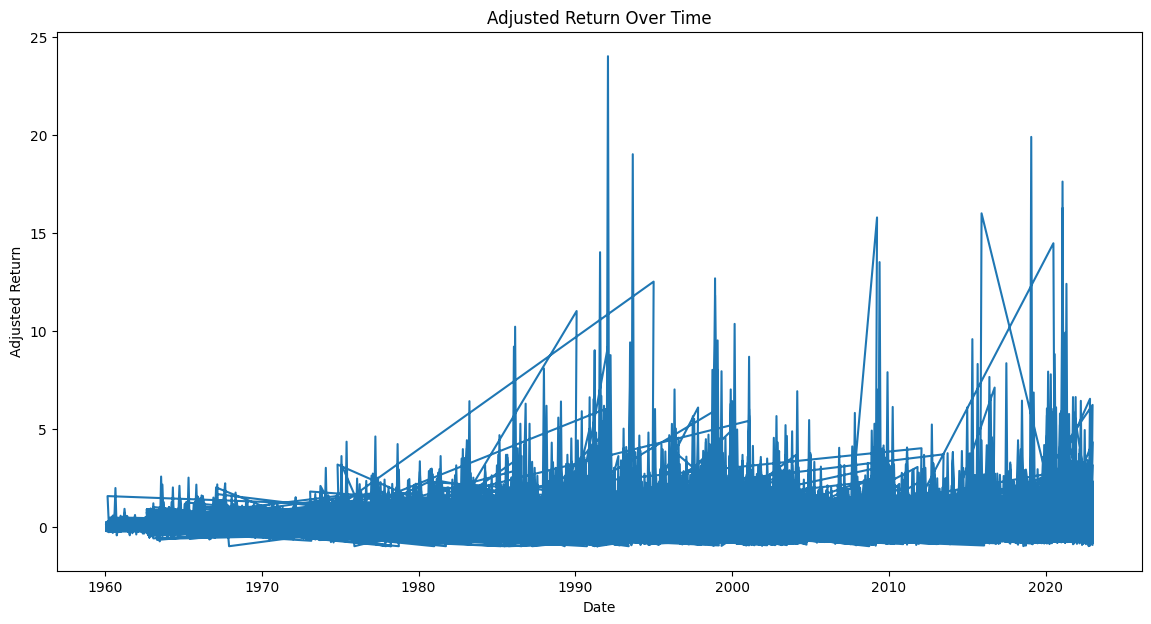

In [51]:
# Plotting 'ret_adj' over time
plt.figure(figsize=(14,7))
plt.plot(crsp['date'], crsp['ret_adj'])
plt.title('Adjusted Return Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Return')
plt.show()

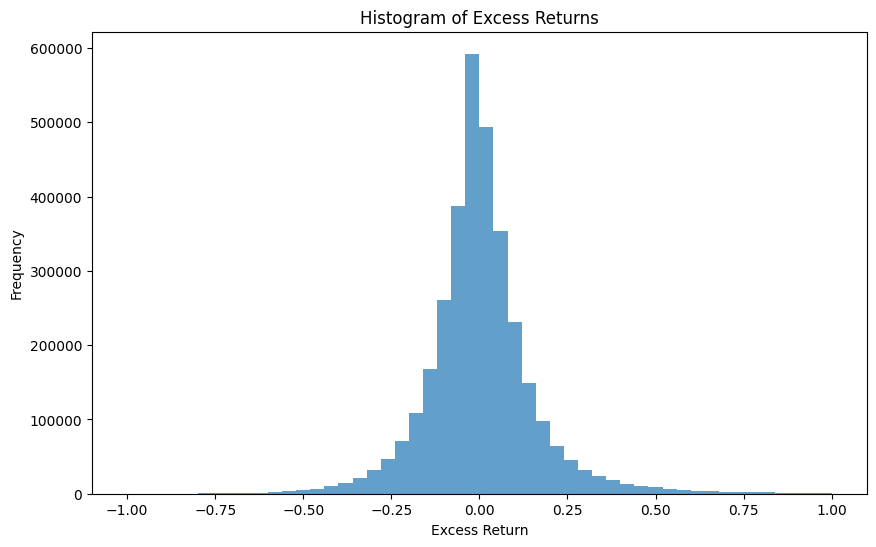

In [58]:
plt.figure(figsize=(10,6))
plt.hist(crsp['ret_excess'].dropna(), range=(-1, 1), bins=50, alpha=0.7)
plt.title('Histogram of Excess Returns')
plt.xlabel('Excess Return')
plt.ylabel('Frequency')
plt.show()

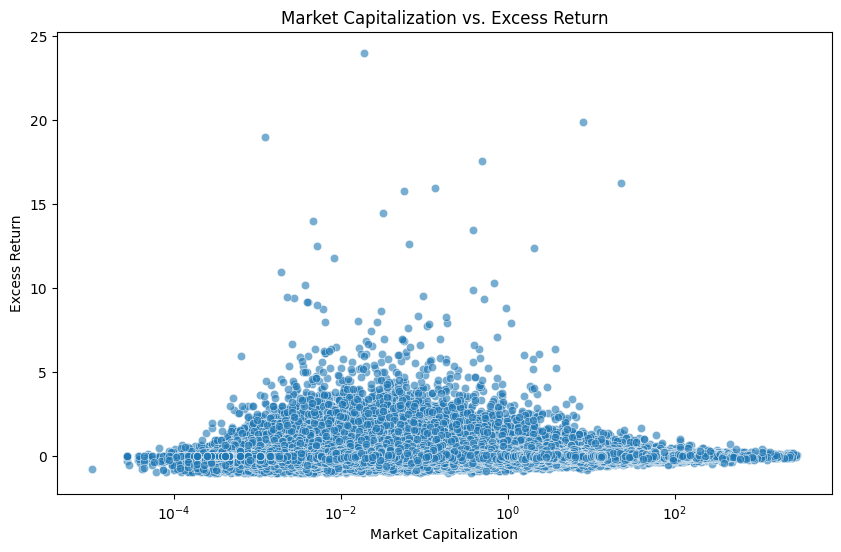

In [59]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=crsp, x='mkt_cap', y='ret_excess', alpha=0.6)
plt.title('Market Capitalization vs. Excess Return')
plt.xlabel('Market Capitalization')
plt.ylabel('Excess Return')
plt.xscale('log')  # Using log scale due to wide range of values
plt.show()

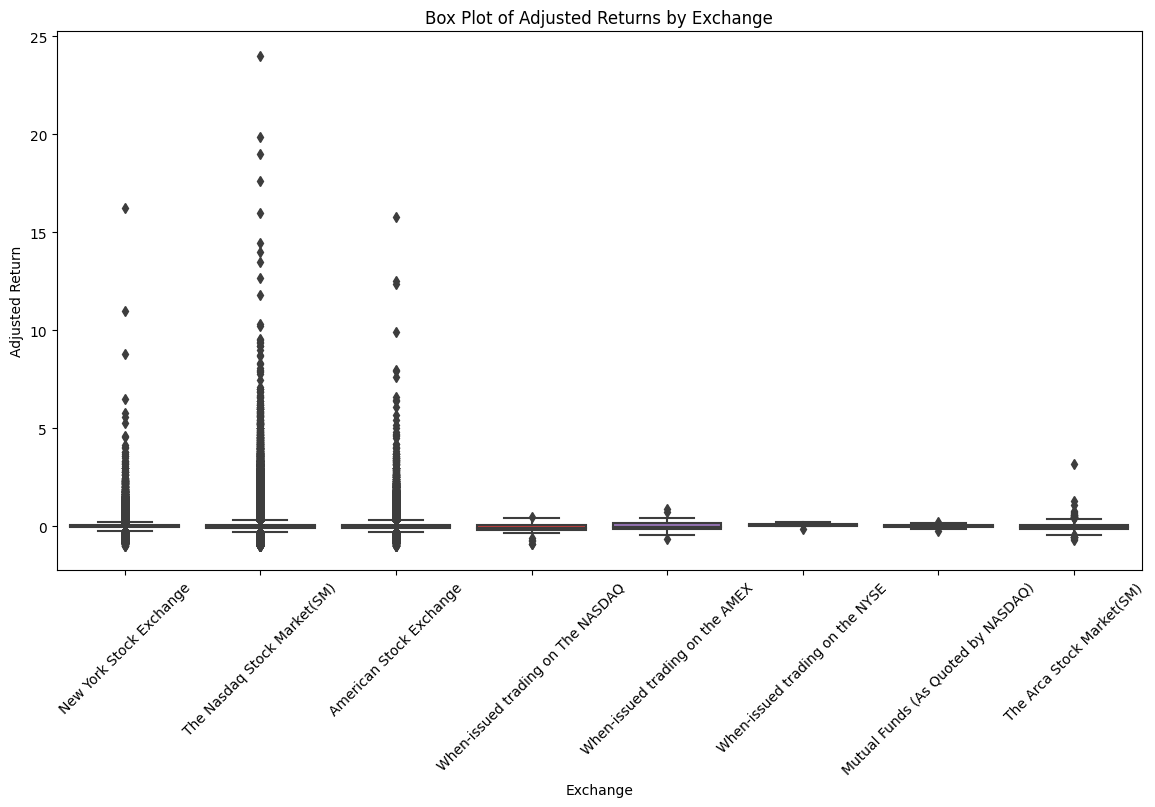

In [55]:
plt.figure(figsize=(14,7))
sns.boxplot(data=crsp, x='exchange', y='ret_adj')
plt.title('Box Plot of Adjusted Returns by Exchange')
plt.xlabel('Exchange')
plt.ylabel('Adjusted Return')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()
